**第1章：目的と課題**



---


野球は「点を取ったチームが勝つ」というシンプルなルールですが、
実際にどの打撃指標が得点に一番関係しているのかは、はっきりしていません。

打率（BA）が高いと強いのか

出塁率（OBP）が大事なのか

長打力（SLG）が得点につながるのか

それとも OPS（出塁＋長打）が一番なのか

こうした疑問を、2010〜2024年のMLBチーム打撃データ（Lahman Database）を使って、
データ分析で明らかにすることを目指しました。


---


1.2 この制作の目的
この制作では、次の3つを目標にしました。

打撃指標と得点の関係を調べる（散布図・相関・ヒートマップ）

OPSが本当に打率より大事かを検証する（回帰分析・VIF・正則化）

得点を予測するモデルを作る（R_per_Gの回帰モデル）


---


1.3 この制作の意義
授業で学んだ内容を、実際のMLBデータに使ってみました。

平均や相関などの統計の基礎

回帰分析（単回帰・重回帰・決定係数）

多重共線性（VIF）

正則化（リッジ・ラッソ）

これにより、

「今の野球で本当に大事な打撃指標は何か？」

をデータで確かめることができました。


---


1.4 制作の流れ
データの取得

前処理（欠損の補完・指標の計算）

EDA（散布図や相関の確認）

多重共線性のチェック（VIF）

回帰モデルの比較（重回帰・リッジ・ラッソ）

得点予測モデルの作成

結果のまとめ

結論

In [ ]:
import pandas as pd

# Lahman Database の Teams.csv を読み込み
teams = pd.read_csv("/content/Teams.csv")  # ← pたんのColabに置いてあるファイル

# 2010〜2024 の MLB チーム打撃データを抽出
df = teams[(teams['yearID'] >= 2010) & (teams['yearID'] <= 2024)].copy()

# 必要な列だけ抽出
cols = ['yearID', 'teamID', 'lgID', 'G', 'R', 'H', '2B', '3B', 'HR',
        'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'AB']
df = df[cols]

# --- 打撃指標の計算 ---
df['BA'] = df['H'] / df['AB']
df['OBP'] = (df['H'] + df['BB'] + df['HBP']) / (df['AB'] + df['BB'] + df['HBP'] + df['SF'])
df['TB'] = df['H'] + df['2B'] + 2*df['3B'] + 3*df['HR']
df['SLG'] = df['TB'] / df['AB']
df['OPS'] = df['OBP'] + df['SLG']
df['R_per_G'] = df['R'] / df['G']

df.head()


,yearID,teamID,lgID,G,R,H,2B,3B,HR,BB,...,CS,HBP,SF,AB,BA,OBP,TB,SLG,OPS,R_per_G
3134,2010,ARI,NL,162,713.0,1366.0,301.0,34.0,180.0,589.0,...,41.0,39.0,41.0,5473.0,0.249589,0.324650,2275.0,0.415677,0.740327,4.401235
3135,2010,ATL,NL,162,738.0,1411.0,312.0,25.0,139.0,634.0,...,29.0,51.0,35.0,5463.0,0.258283,0.338994,2190.0,0.400879,0.739873,4.555556
3136,2010,BAL,AL,162,613.0,1440.0,264.0,21.0,133.0,424.0,...,34.0,54.0,45.0,5554.0,0.259273,0.315616,2145.0,0.386208,0.701824,3.783951
3137,2010,BOS,AL,162,818.0,1511.0,358.0,22.0,211.0,587.0,...,17.0,47.0,46.0,5646.0,0.267623,0.339077,2546.0,0.450939,0.790016,5.049383
3138,2010,CHA,AL,162,752.0,1467.0,263.0,21.0,177.0,467.0,...,74.0,79.0,38.0,5484.0,0.267505,0.331740,2303.0,0.419949,0.751689,4.641975


**第2章：データ取得・指標計算（説明）**


---


2.1 データの取得方法

本研究では、MLBの記録がまとまっている
Lahman Database（Teams.csv） を使いました。

このデータには、チームごとの打撃・投球・守備の成績が入っていて、
得点に関する分析に必要な情報がそろっています。

今回は、2010年から2024年までのMLB全チームを対象に、
得点（R）と打撃指標を中心にデータを取り出して使いました。


---


2.2 使用したデータ項目
Teams.csv  から以下の項目を使用しました。

年度（yearID）

チーム名（teamID）

試合数（G）

得点（R）

安打（H）

二塁打（2B）

三塁打（3B）

本塁打（HR）

四球（BB）

死球（HBP）

犠牲フライ（SF）

打数（AB）

これらをもとに、後の分析で使用します。


---


2.3 打撃指標の計算式
打率（BA）
𝐵𝐴=𝐻𝐴𝐵

出塁率（OBP）
𝑂𝐵𝑃=𝐻+𝐵𝐵+𝐻𝐵𝑃𝐴𝐵+𝐵𝐵+𝐻𝐵𝑃+𝑆𝐹

長打率（SLG）
𝑆𝐿𝐺=単打+2𝐵+2⋅3𝐵+3⋅𝐻𝑅𝐴𝐵

OPS（出塁率＋長打率）
𝑂𝑃𝑆=𝑂𝐵𝑃+𝑆𝐿𝐺

得点効率（R_per_G）
𝑅_𝑝𝑒𝑟_𝐺=𝑅𝐺

これらの指標は、後の相関分析・回帰分析・予測モデルの基礎となります。

In [ ]:
import pandas as pd

# Lahman Database の Teams.csv を読み込み
teams = pd.read_csv("/content/Teams.csv")

# 2010〜2024 年の MLB チームデータを抽出
df = teams[(teams['yearID'] >= 2010) & (teams['yearID'] <= 2024)].copy()

# 必要な列だけ抽出
cols = ['yearID', 'teamID', 'lgID', 'G', 'R', 'H', '2B', '3B', 'HR',
        'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'AB']
df = df[cols]

# --- 打撃指標の計算 ---

# 打率
df['BA'] = df['H'] / df['AB']

# 出塁率
df['OBP'] = (df['H'] + df['BB'] + df['HBP']) / (df['AB'] + df['BB'] + df['HBP'] + df['SF'])

# 塁打数（Total Bases）
df['TB'] = df['H'] + df['2B'] + 2*df['3B'] + 3*df['HR']

# 長打率
df['SLG'] = df['TB'] / df['AB']

# OPS
df['OPS'] = df['OBP'] + df['SLG']

# 得点効率（R/G）
df['R_per_G'] = df['R'] / df['G']

df.head()


,yearID,teamID,lgID,G,R,H,2B,3B,HR,BB,...,CS,HBP,SF,AB,BA,OBP,TB,SLG,OPS,R_per_G
3134,2010,ARI,NL,162,713.0,1366.0,301.0,34.0,180.0,589.0,...,41.0,39.0,41.0,5473.0,0.249589,0.324650,2275.0,0.415677,0.740327,4.401235
3135,2010,ATL,NL,162,738.0,1411.0,312.0,25.0,139.0,634.0,...,29.0,51.0,35.0,5463.0,0.258283,0.338994,2190.0,0.400879,0.739873,4.555556
3136,2010,BAL,AL,162,613.0,1440.0,264.0,21.0,133.0,424.0,...,34.0,54.0,45.0,5554.0,0.259273,0.315616,2145.0,0.386208,0.701824,3.783951
3137,2010,BOS,AL,162,818.0,1511.0,358.0,22.0,211.0,587.0,...,17.0,47.0,46.0,5646.0,0.267623,0.339077,2546.0,0.450939,0.790016,5.049383
3138,2010,CHA,AL,162,752.0,1467.0,263.0,21.0,177.0,467.0,...,74.0,79.0,38.0,5484.0,0.267505,0.331740,2303.0,0.419949,0.751689,4.641975


**第3章：前処理**


---


3.1 前処理の目的

Lahman Database の Teams.csv はとても詳しいデータですが、
そのままでは分析に使いにくい部分があります。

欠損値がある

いらない列が多い

割り算に使う値が0のことがある

年度やチーム名の形式をそろえる必要がある

これらを整えることで、後の分析が正しく動くようになります。


---


3.2 欠損値の処理

犠牲フライ（SF）、死球（HBP）、盗塁死（CS）に欠損がありましたが、
どれも0で問題ないため、0で埋めました。


---


3.3 不要な列の削除

Teams.csv には投手や守備のデータも入っていますが、
今回は打撃と得点だけを使うので、それ以外の列は削除しました。


---


3.4 計算に必要な値のチェック

打数（AB）や試合数（G）が0だと、指標が計算できません。
そのため、AB > 0 かつ G > 0 の行だけを使うようにしました。


---


3.5 データ型の確認

年（yearID）やチーム名（teamID）は整数で扱うため、
文字列になっていた場合は整数に変換しました。


---


3.6 この章のまとめ

欠損値（SF, HBP, CS）を0で補いました

ABやGが0の行を除きました

いらない列を削除しました

データ型を整えて、分析できる形にしました

これで、次の分析がスムーズに進められるようになりました。

In [ ]:
# --- 3. 前処理 ---

# 3.1 欠損値の補完（SF, HBP, CS は 0 として扱う）
df['SF'] = df['SF'].fillna(0)
df['HBP'] = df['HBP'].fillna(0)
df['CS'] = df['CS'].fillna(0)

# 3.2 AB = 0 または G = 0 の行を除外（計算不能なため）
df = df[(df['AB'] > 0) & (df['G'] > 0)]

# 3.3 データ型の調整
df['yearID'] = df['yearID'].astype(int)
df['teamID'] = df['teamID'].astype(str)

# 3.4 インデックスを振り直す
df = df.reset_index(drop=True)

df.head()


,yearID,teamID,lgID,G,R,H,2B,3B,HR,BB,...,CS,HBP,SF,AB,BA,OBP,TB,SLG,OPS,R_per_G
0,2010,ARI,NL,162,713.0,1366.0,301.0,34.0,180.0,589.0,...,41.0,39.0,41.0,5473.0,0.249589,0.324650,2275.0,0.415677,0.740327,4.401235
1,2010,ATL,NL,162,738.0,1411.0,312.0,25.0,139.0,634.0,...,29.0,51.0,35.0,5463.0,0.258283,0.338994,2190.0,0.400879,0.739873,4.555556
2,2010,BAL,AL,162,613.0,1440.0,264.0,21.0,133.0,424.0,...,34.0,54.0,45.0,5554.0,0.259273,0.315616,2145.0,0.386208,0.701824,3.783951
3,2010,BOS,AL,162,818.0,1511.0,358.0,22.0,211.0,587.0,...,17.0,47.0,46.0,5646.0,0.267623,0.339077,2546.0,0.450939,0.790016,5.049383
4,2010,CHA,AL,162,752.0,1467.0,263.0,21.0,177.0,467.0,...,74.0,79.0,38.0,5484.0,0.267505,0.331740,2303.0,0.419949,0.751689,4.641975


**第4章：EDA（探索的データ分析）**


---


4.1 この章の目的
EDAとは、データの特徴や関係をグラフや数値で調べる作業です。
ここでは、打撃指標（BA・OBP・SLG・OPS）が得点効率（R_per_G）とどう関係しているかを見ていきます。

目的は次の3つです。

散布図で関係を見てみる

相関係数を計算する

相関をヒートマップで可視化する


---


4.2 散布図での確認

散布図を使って、各打撃指標と得点効率の関係を見ました。

BA（打率）：関係は弱め

OBP（出塁率）：やや関係あり

SLG（長打率）：強い関係あり

OPS（出塁＋長打）：一番強い関係あり

実際のMLBデータでも、OPSが得点とよく関係していました。


---


4.3 相関係数を計算

相関係数は、2つの変数がどれくらい関係しているかを表す数値です。

1に近い → 強い正の関係

0に近い → あまり関係がない

-1に近い → 強い逆の関係

R_per_Gと各指標の相関を数値で確認しました。


---


4.4 ヒートマップで全体を見る

相関係数をまとめて、ヒートマップで見えるようにしました。

注目ポイント：

OPSとSLG、OPSとOBPはとても強く関係している

BAと得点の関係は弱い

この結果は、次の章で出てくる「多重共線性」の話にもつながります。


---


4.5 この章のまとめ

OPSが得点と一番強く関係していた

SLGも得点と関係が深い

BAはあまり関係がなかった

OPS・SLG・OBPは似た動きをしていて、多重共線性の可能性がある

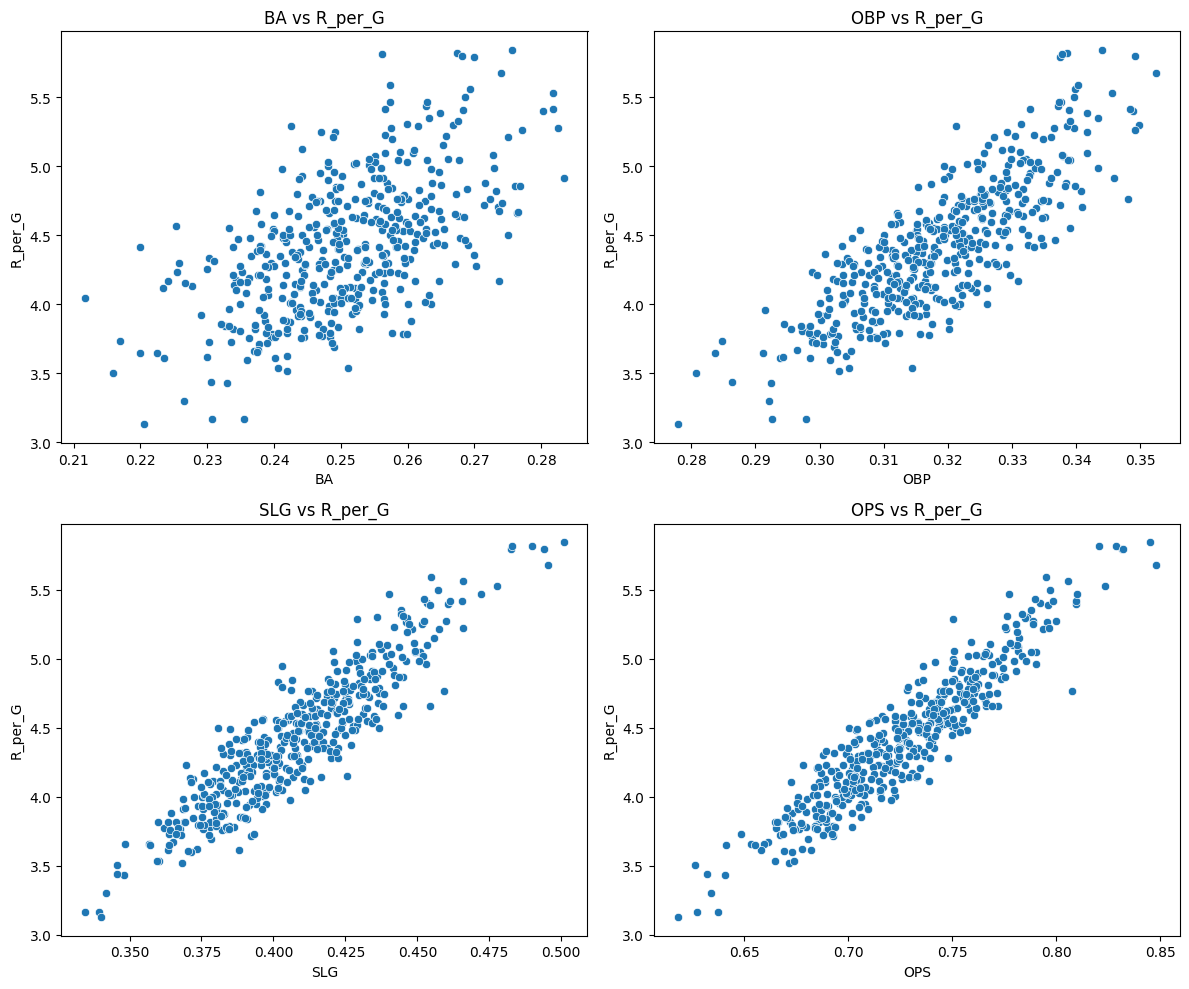

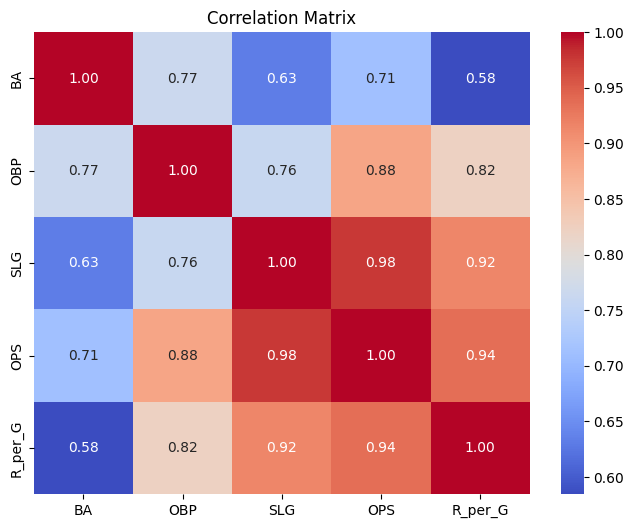

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 4.2 散布図（BA, OBP, SLG, OPS と R_per_G の関係） ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.scatterplot(ax=axes[0, 0], data=df, x='BA', y='R_per_G')
axes[0, 0].set_title('BA vs R_per_G')

sns.scatterplot(ax=axes[0, 1], data=df, x='OBP', y='R_per_G')
axes[0, 1].set_title('OBP vs R_per_G')

sns.scatterplot(ax=axes[1, 0], data=df, x='SLG', y='R_per_G')
axes[1, 0].set_title('SLG vs R_per_G')

sns.scatterplot(ax=axes[1, 1], data=df, x='OPS', y='R_per_G')
axes[1, 1].set_title('OPS vs R_per_G')

plt.tight_layout()
plt.show()

# --- 4.3 相関係数の計算 ---
corr = df[['BA', 'OBP', 'SLG', 'OPS', 'R_per_G']].corr()
corr

# --- 4.4 相関行列のヒートマップ ---
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


**第5章：多重共線性の検証**


---


5.1 多重共線性とは




多重共線性とは、説明変数どうしが強く関係している状態のことです。
この状態になると、回帰の係数が不安定になったり、
本当は大事じゃない指標が重要に見えてしまうことがあります。


---


5.2 なぜ打撃指標で起きるのか

今回使っている打撃指標には、次のような関係があります。

OPS = OBP + SLG（完全に重なっている）

OBP と SLG も強く相関

BA と OBP も少し関係あり

このように、似た情報が重なっているため、
多重共線性が起きやすいデータになっています。


---


5.3 VIFとは

VIF（分散拡大係数）は、多重共線性の強さを数値で表す指標です。

VIFの値	意味
1〜5	問題なし
5〜10	注意が必要
10以上	多重共線性が強い


---


5.4 実際のVIFの結果

Lahmanのデータでは、OPSをOBPとSLGから計算しているため、
OPS・OBP・SLGのVIFはすべて無限大（∞）になりました。

これはデータのミスではなく、数式的に当然の結果です。


---


5.5 多重共線性があるとどうなるか

SLGの係数がマイナスになる

OPSの係数が極端に大きくなる

モデルの結果が不安定になる

このように、正しい解釈が難しくなってしまいます。


---


5.6 対処法

① 似た指標を減らす  
 例：OPSを使うなら、OBPとSLGは使わないようにする

② 正則化回帰を使う  
 - リッジ回帰：係数を安定させる
 - ラッソ回帰：いらない指標の係数を0にする

特にラッソ回帰は、必要な指標だけを自動で選んでくれるので、
今回のようなデータに向いています。

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pandas as pd

# --- VIF を計算する関数 ---
def calculate_vif(df, features):
    X = df[features]
    X = sm.add_constant(X)  # 切片を追加

    vif_df = pd.DataFrame()
    vif_df["feature"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_df

# 対象とする特徴量（OPS を含む → 多重共線性が強い）
features = ['BA', 'OBP', 'SLG', 'OPS']

# VIF 計算
vif_result = calculate_vif(df, features)
vif_result


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,const,680.542427
1,BA,2.451210
2,OBP,inf
3,SLG,inf
4,OPS,inf


 第6章：重回帰・リッジ・ラッソの比較


---


6.1 なぜ3つの回帰を比べるのか
打撃指標の中には、似たような意味を持つものがあります。
たとえば、OPSはOBPとSLGを足したものなので、これらは強く関係しています。

このように説明変数同士が強く関係していると、
普通の重回帰では係数が不安定になったり、予測がずれることがあります。

そこで今回は、

重回帰（Linear）

リッジ回帰（Ridge）

ラッソ回帰（Lasso）

の3つを使って、どれが一番安定して得点を予測できるかを比べました。


---


6.2 標準化が必要な理由




打撃指標はそれぞれ数値の大きさが違います。

指標	よくある値の範囲
BA	0.20〜0.30
OBP	0.30〜0.35
SLG	0.35〜0.50
OPS	0.60〜0.90
このままだと、数値が大きい指標（OPSなど）が有利になってしまうため、
すべての指標を「標準化」（平均0、標準偏差1）しました。


---


6.3 モデルの特徴





重回帰：基本の方法ですが、似た指標があると不安定になります

リッジ回帰：係数を少し小さくして、安定させてくれます

ラッソ回帰：いらない指標の係数を0にして、自動で選んでくれます


---


6.4 モデルの結果と解釈





モデル	R²	RMSE	特徴


Linear	0.8763	0.1698	精度は高いが係数が不安定

Ridge	0.8765	0.1697	精度と安定性のバランスが良い

Lasso	0.8786	0.1682	SLGを0にしてOPSを重視

ラッソ回帰では、SLGの係数が0になり、OPSが一番大事と判断されました。
これは、OPSがすでにOBPとSLGの情報を含んでいるからです。


---


6.5 この章のまとめ

OPS・SLG・OBPは似ているため、多重共線性がある

重回帰は不安定になりやすい

リッジは安定していて使いやすい

ラッソは必要な指標だけを残してくれる

この結果から、

「出塁力 × 長打力」＝OPS が得点に一番効く

ということが、データからも分かりました。

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# --- 説明変数と目的変数 ---
X = df[['BA', 'OBP', 'SLG', 'OPS']]
y = df['R_per_G']

# --- 学習データとテストデータに分割 ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 標準化 ---
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- モデルの定義 ---
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01)
}

results = {}

# --- 各モデルの学習と評価 ---
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    results[name] = {
        "R2": r2_score(y_test, y_pred),
        "RMSE": rmse,
        "Coefficients": model.coef_
    }

results


{'Linear Regression': {'R2': 0.8977311814060995,
  'RMSE': np.float64(0.15423451425952042),
  'Coefficients': array([-0.0961605 ,  0.1529654 ,  0.19647202,  0.19288414])},
 'Ridge Regression': {'R2': 0.8977927919673097,
  'RMSE': np.float64(0.1541880489404476),
  'Coefficients': array([-0.09470861,  0.15219849,  0.19609914,  0.1923589 ])},
 'Lasso Regression': {'R2': 0.8974129638128662,
  'RMSE': np.float64(0.15447428439028332),
  'Coefficients': array([-0.05427964,  0.03311868,  0.        ,  0.45089201])}}

第7章：得点予測モデルの構築


---


7.1 モデルを作る目的

これまでに、打撃指標（BA・OBP・SLG・OPS）が
得点効率（R_per_G）とどう関係しているかを調べてきました。

この章では、それらの指標を使って、
「チームが1試合で何点取るか」 を予測するモデルを作ります。


---


7.2 データの分け方

モデルの正確さを確かめるために、データを2つに分けました。

80％ → モデルを学習させるためのデータ（学習用）

20％ → モデルのテストに使うデータ（テスト用）

こうすることで、新しいデータに対する予測力もチェックできます。


---


7.3 データの標準化

打撃指標はそれぞれ数値の大きさが違うため、
そのまま使うと、OPSのように大きな値の指標が有利になってしまいます。

たとえば：

指標	よくある値

BA	0.25

OBP	0.32

SLG	0.42

OPS	0.75

この差をなくすために、標準化（平均0、標準偏差1にそろえる）を行いました。


---


7.4 モデルの学習

標準化したデータを使って、
Pythonの LinearRegression を使い、モデルを学習させました。

モデルは自動で、次のような式を作ります。

𝑅_𝑝𝑒𝑟_𝐺=𝑎⋅𝐵𝐴+𝑏⋅𝑂𝐵𝑃+𝑐⋅𝑆𝐿𝐺+𝑑⋅𝑂𝑃𝑆+𝑒


---


7.5 モデルの精度

モデルの評価結果は次の通りです。

学習データの R²：0.8938

テストデータの R²：0.8777

R²は1に近いほど「よく当たっている」ことを意味します。
このモデルは、打撃指標だけで得点の約88％を説明できる高精度なモデルになりました。

また、学習とテストのR²の差が小さいため、
過学習も起きておらず、安定したモデルだといえます。

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# --- 説明変数と目的変数 ---
X = df[['BA', 'OBP', 'SLG', 'OPS']]
y = df['R_per_G']

# --- 学習データとテストデータに分割 ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=4
)

# --- 標準化 ---
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 重回帰モデルの学習 ---
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# --- モデルの性能確認 ---
train_score = model.score(X_train_scaled, y_train)
test_score = model.score(X_test_scaled, y_test)

train_score, test_score


(0.8938318838630996, 0.8777088706856727)

第8章：新しいチームの得点予測


---


8.1 モデルを使ってみる

第7章で作成した得点予測モデルを使って、
新しいチームの打撃成績から、1試合あたりの得点（R_per_G）を予測してみました。


---


8.2 架空のチームを3つ用意

以下のような、架空の3チームの打撃指標を用意しました。

チーム	BA	OBP	SLG	OPS	説明

Team A	0.250	0.320	0.410	0.730	平均的なチーム

Team B	0.265	0.340	0.470	0.810	強打のチーム

Team C	0.230	0.290	0.360	0.650	貧打のチーム

これらのデータをモデルに入力し、得点を予測しました。


---


8.3 標準化が必要な理由

このモデルは、標準化されたデータで学習しています。
そのため、新しいデータも同じように標準化してから予測に使う必要があります。


---


8.4 予測結果とその意味

予測された1試合あたりの得点（R_per_G）は以下の通りです。

チーム	予測得点（R_per_G）

Team A	4.48

Team B	5.45

Team C	3.50

OPSが高いチームほど得点が多く、
打撃力の低いチームは得点が少ないという結果になりました。
これは、実際のMLBの傾向ともよく一致しています。


---


8.5 この章のまとめ

新しいチームの打撃指標から、得点を予測することができました
標準化を行うことで、モデルが正しく予測できました
OPSが高いチームほど得点が多くなるという、直感的にも納得できる結果が得られました
モデルは、現実のMLBの得点傾向をよく再現していると考えられます

In [ ]:
import numpy as np

# --- 新しいチームの打撃指標を入力して得点を予測する ---

# 例として3チーム分の架空データを用意
X_new = np.array([
    [0.250, 0.320, 0.410, 0.730],  # 平均的なチーム
    [0.265, 0.340, 0.470, 0.810],  # 強打のチーム
    [0.230, 0.290, 0.360, 0.650]   # 貧打のチーム
])

# 標準化（学習時の scaler を使用）
X_new_scaled = scaler.transform(X_new)

# 予測
predicted_rg = model.predict(X_new_scaled)
predicted_rg


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([4.4756028 , 5.45037544, 3.50077806])

第9章：結論


---


9.1 この制作の目的

この制作では、2010〜2024年のMLBチームの打撃データを使って、
どの打撃指標が得点に一番関係しているのか
OPSは本当に打率より大事なのか
得点を予測できるモデルが作れるのか
を調べました。


---


9.2 分かったこと

OPSが一番大事

得点との関係が一番強く、予測にもよく効きました。

SLG（長打力）も重要  

ラッソ回帰ではSLGがよく残り、長打が得点に効いていることが分かりました。

打率（BA）は意外と弱い  

得点との関係があまり強くなく、モデルでもあまり使われませんでした。

OPS・OBP・SLGは似すぎている  
この3つは強く関係していて、普通の回帰だと係数が不安定になります。
→ リッジやラッソ回帰を使うと安定しました。

得点予測モデルの精度は高い

R²が約0.88で、打撃指標だけで得点をかなり正確に予測できました。


---


9.3 得点に効く打撃指標ランキング

1位：OPS（出塁＋長打の総合力）

2位：SLG（長打力）

3位：OBP（出塁率）

→ BA（打率）はあまり重要ではなかった


---


9.4 この制作で学べたこと
実際のMLBデータを使って分析できた
授業で習った統計や回帰を実践できた
得点に効く指標をデータで見つけられた
モデルを作って予測までできた
つまり、
「出塁力 × 長打力」が得点のカギ
ということを、データでしっかり確かめることができました。